In [1]:
import datetime
import pickle
import polars as pl
import ml_utils
import mlflow
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
import constants
import numpy as np
import optuna
from optuna.integration.mlflow import MLflowCallback

In [2]:
with open("df_all.pkl", "rb") as file:
    df_all = pickle.load(file)

In [3]:
df_all = df_all.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df_all.head(8)

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16
2006-01-01,152,139,194,40,525,0,0,0,0,7,1,1
2006-01-02,53,43,112,19,227,0,0,0,0,1,1,2
2006-01-03,29,21,56,6,112,0,0,0,0,2,1,3
2006-01-04,92,98,165,36,391,0,0,0,0,3,1,4
2006-01-05,149,198,193,42,582,0,0,0,0,4,1,5
2006-01-06,94,77,126,27,324,0,0,0,0,5,1,6
2006-01-07,29,28,48,13,118,0,0,0,0,6,1,7
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8


In [4]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [5]:
df_all

date,a,b,o,ab,all,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,weekday,month,day_of_year,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i64,i64,i64,i64,u8,u8,u8,u8,i8,i8,i16,i64,i64,i64,i64,i64,i64,i64
2006-01-08,218,212,314,51,795,0,0,0,0,7,1,8,118,324,582,391,112,227,525
2006-01-09,83,95,151,17,346,0,0,0,0,1,1,9,795,118,324,582,391,112,227
2006-01-10,1,0,1,0,2,0,0,1,0,2,1,10,346,795,118,324,582,391,112
2006-01-11,128,111,179,30,448,0,0,0,0,3,1,11,2,346,795,118,324,582,391
2006-01-12,211,236,316,42,805,0,0,0,0,4,1,12,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-27,287,319,517,58,1181,0,0,0,0,2,5,147,1024,3215,2123,993,1626,1514,1843
2025-05-28,342,399,625,73,1439,0,0,0,0,3,5,148,1181,1024,3215,2123,993,1626,1514
2025-05-29,341,395,596,47,1379,0,0,0,0,4,5,149,1439,1181,1024,3215,2123,993,1626


In [6]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [7]:
# Set up scalers 
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
X_scaler = StandardScaler()

In [8]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [9]:
with open('x_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)
    
with open('y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)

In [10]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_split_lstm_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [ ]:
experiment_name = f"{constants.EXPERIMENT_NAME}_{datetime.datetime.now().strftime('%Y%m%d')}"
experiment_id = ml_utils.get_or_create_mlflow_experiment(experiment_name)
mlflow.set_experiment(experiment_name)
mlflow_callback = MLflowCallback(
    tracking_uri = mlflow.get_tracking_uri(),
    metric_name = "val_loss"
)

In [12]:
def objective(trial):
    seq_type = trial.suggest_categorical("seq_type", ["LSTM", "SimpleRNN", "GRU"])
    seq_units = trial.suggest_int("seq_units", 12, 64)
    dense_units = trial.suggest_int("dense_units", 4, 12)
    activation = trial.suggest_categorical("activation", ["relu", "mish", "sigmoid"])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    dropout = trial.suggest_float("dropout", 0.01, 0.2)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)  # log scale for LR
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    
    ml_utils.run_experiment(
        X_seq_train, X_features_train, y_train,
        X_seq_val, X_features_val, y_val,
        seq_type=seq_type,
        seq_units=seq_units,
        dense_units=dense_units,
        activation=activation,
        optimizer=optimizer,
        dropout=dropout,
        learning_rate=learning_rate,
        batch_size=batch_size,
        experiment_id=experiment_id
    )
    
    runs = mlflow.search_runs(experiment_ids=[experiment_id], order_by=["metrics.val_loss DESC"])
    val_loss = runs.iloc[0]["metrics.val_loss"]
    return val_loss

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=constants.N_TRIALS, callbacks=[mlflow_callback])

[I 2025-06-01 10:39:03,576] A new study created in memory with name: no-name-a818479e-7307-48a8-9ef4-71a82f2f6066


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3472 - mae: 0.4213 
Validation Loss: 0.4009554088115692, Validation MAE: 0.452402263879776


[I 2025-06-01 10:39:35,422] Trial 0 finished with value: 0.4874158203601837 and parameters: {'seq_type': 'LSTM', 'seq_units': 57, 'dense_units': 6, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.19254804655286312, 'learning_rate': 0.07390158445226248, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.
2025/06/01 10:39:35 INFO mlflow.tracking.fluent: Experiment with name 'no-name-a818479e-7307-48a8-9ef4-71a82f2f6066' does not exist. Creating a new experiment.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2448 - mae: 0.3493 
Validation Loss: 0.28440961241722107, Validation MAE: 0.3790389597415924


[I 2025-06-01 10:41:13,669] Trial 1 finished with value: 0.4874158203601837 and parameters: {'seq_type': 'GRU', 'seq_units': 17, 'dense_units': 9, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.10266534184804123, 'learning_rate': 0.06864089849960851, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3006 - mae: 0.3736
Validation Loss: 0.3153177797794342, Validation MAE: 0.3890756368637085


[I 2025-06-01 10:44:55,312] Trial 2 finished with value: 0.4874158203601837 and parameters: {'seq_type': 'GRU', 'seq_units': 15, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.0532208265270686, 'learning_rate': 0.00023981179550705662, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3138 - mae: 0.4140
Validation Loss: 0.3359978199005127, Validation MAE: 0.42847782373428345


[I 2025-06-01 10:45:55,640] Trial 3 finished with value: 0.4874158203601837 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 43, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.04305412254863414, 'learning_rate': 0.045546425190813936, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2521 - mae: 0.3491
Validation Loss: 0.27312177419662476, Validation MAE: 0.3682532012462616


[I 2025-06-01 10:46:54,426] Trial 4 finished with value: 0.4874158203601837 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 46, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0750933766480435, 'learning_rate': 0.0030351208325453496, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0154 - mae: 0.7635
Validation Loss: 1.1188957691192627, Validation MAE: 0.804219663143158


[I 2025-06-01 10:50:24,035] Trial 5 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 55, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.08601929589746997, 'learning_rate': 0.08012952335730351, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2728 - mae: 0.3682
Validation Loss: 0.29434189200401306, Validation MAE: 0.384472131729126


[I 2025-06-01 10:59:22,667] Trial 6 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 41, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.1278503565011293, 'learning_rate': 0.00011913931195222535, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3026 - mae: 0.3704
Validation Loss: 0.3089635670185089, Validation MAE: 0.3814390301704407


[I 2025-06-01 11:02:13,824] Trial 7 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 25, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.18487713018362353, 'learning_rate': 0.0006094998943043811, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2807 - mae: 0.3720
Validation Loss: 0.3076348304748535, Validation MAE: 0.3932841122150421


[I 2025-06-01 11:03:34,697] Trial 8 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 20, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.19813684241099208, 'learning_rate': 0.0006801226353868108, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2910 - mae: 0.3847
Validation Loss: 0.3261719346046448, Validation MAE: 0.40834325551986694


[I 2025-06-01 11:07:10,920] Trial 9 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 28, 'dense_units': 5, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.17189015022359963, 'learning_rate': 0.0001933843838982532, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2331 - mae: 0.3438
Validation Loss: 0.25623929500579834, Validation MAE: 0.3627222776412964


[I 2025-06-01 11:10:45,420] Trial 10 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 64, 'dense_units': 12, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.14454442650967347, 'learning_rate': 0.014527470565287689, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2433 - mae: 0.3517
Validation Loss: 0.2699183523654938, Validation MAE: 0.371273398399353


[I 2025-06-01 11:13:12,130] Trial 11 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'GRU', 'seq_units': 31, 'dense_units': 7, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.10864320588358878, 'learning_rate': 0.017143599650575676, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2162 - mae: 0.3311
Validation Loss: 0.2511945962905884, Validation MAE: 0.35750001668930054


[I 2025-06-01 11:16:29,655] Trial 12 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'GRU', 'seq_units': 12, 'dense_units': 11, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.15140787982908682, 'learning_rate': 0.019052790833126172, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2688 - mae: 0.3592
Validation Loss: 0.2805638611316681, Validation MAE: 0.3686867356300354


[I 2025-06-01 11:19:46,648] Trial 13 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'GRU', 'seq_units': 53, 'dense_units': 6, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.1080851907086271, 'learning_rate': 0.004502985580957912, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2954 - mae: 0.3993
Validation Loss: 0.34988123178482056, Validation MAE: 0.4385513961315155


[I 2025-06-01 11:21:37,977] Trial 14 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 36, 'dense_units': 10, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.011330045211399312, 'learning_rate': 0.08838455307553114, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2468 - mae: 0.3572
Validation Loss: 0.2613915801048279, Validation MAE: 0.37282851338386536


[I 2025-06-01 11:25:04,345] Trial 15 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'GRU', 'seq_units': 60, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.15963146887525673, 'learning_rate': 0.0056220845518735645, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2628 - mae: 0.3643
Validation Loss: 0.30139872431755066, Validation MAE: 0.3967950642108917


[I 2025-06-01 11:28:43,421] Trial 16 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 51, 'dense_units': 6, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.12751424041504633, 'learning_rate': 0.03265996948635858, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2654 - mae: 0.3577
Validation Loss: 0.2872074544429779, Validation MAE: 0.3745790123939514


[I 2025-06-01 11:31:31,716] Trial 17 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'GRU', 'seq_units': 36, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.08438537841133689, 'learning_rate': 0.001988621244293696, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2629 - mae: 0.3504
Validation Loss: 0.28355494141578674, Validation MAE: 0.3696332573890686


[I 2025-06-01 11:33:13,273] Trial 18 finished with value: 1.1188956499099731 and parameters: {'seq_type': 'LSTM', 'seq_units': 21, 'dense_units': 10, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.1213875218314358, 'learning_rate': 0.008365179496409874, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0154 - mae: 0.7625
Validation Loss: 1.1191819906234741, Validation MAE: 0.8034510016441345


[I 2025-06-01 11:35:21,180] Trial 19 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 59, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.06202111958679476, 'learning_rate': 0.04106106099962547, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2595 - mae: 0.3720
Validation Loss: 0.2835924029350281, Validation MAE: 0.39992088079452515


[I 2025-06-01 11:37:22,408] Trial 20 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 48, 'dense_units': 7, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.029637024340522677, 'learning_rate': 0.0785562561595885, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2825 - mae: 0.3575
Validation Loss: 0.2882651686668396, Validation MAE: 0.3728941082954407


[I 2025-06-01 11:40:17,086] Trial 21 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 12, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.05832227937074613, 'learning_rate': 0.0013299935157295925, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2900 - mae: 0.3671
Validation Loss: 0.3047962486743927, Validation MAE: 0.38006746768951416


[I 2025-06-01 11:46:42,209] Trial 22 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 18, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.042509225810649386, 'learning_rate': 0.0003646275257136861, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2631 - mae: 0.3531
Validation Loss: 0.2720949947834015, Validation MAE: 0.36201536655426025


[I 2025-06-01 11:47:50,761] Trial 23 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 16, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.0925695254567791, 'learning_rate': 0.009237050666915774, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2899 - mae: 0.3723
Validation Loss: 0.2957654893398285, Validation MAE: 0.3842787742614746


[I 2025-06-01 11:50:47,897] Trial 24 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 30, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.06723821505456445, 'learning_rate': 0.0011508672101540366, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2613 - mae: 0.3639
Validation Loss: 0.2885942757129669, Validation MAE: 0.3855300843715668


[I 2025-06-01 11:51:39,404] Trial 25 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.010143592026638767, 'learning_rate': 0.02894564362996588, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2668 - mae: 0.3475
Validation Loss: 0.2894282639026642, Validation MAE: 0.3689996898174286


[I 2025-06-01 11:58:17,890] Trial 26 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 15, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.14003610091515434, 'learning_rate': 0.0003179000202761081, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3051 - mae: 0.4150
Validation Loss: 0.3238993287086487, Validation MAE: 0.42749476432800293


[I 2025-06-01 12:07:15,671] Trial 27 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 24, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.09439233436910105, 'learning_rate': 0.055810761408290444, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2271 - mae: 0.3413
Validation Loss: 0.24829719960689545, Validation MAE: 0.3604423701763153


[I 2025-06-01 12:10:06,354] Trial 28 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 33, 'dense_units': 8, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.04893256469077021, 'learning_rate': 0.024165870176135962, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3152 - mae: 0.3926
Validation Loss: 0.3457004129886627, Validation MAE: 0.4161568284034729


[I 2025-06-01 13:46:20,345] Trial 29 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 40, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.17231272262194916, 'learning_rate': 0.05903360429229155, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2801 - mae: 0.3682
Validation Loss: 0.30364322662353516, Validation MAE: 0.3863222897052765


[I 2025-06-01 13:46:47,971] Trial 30 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 27, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.0346774561219513, 'learning_rate': 0.01097049708298671, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3566 - mae: 0.4038
Validation Loss: 0.3662000298500061, Validation MAE: 0.4209356904029846


[I 2025-06-01 13:47:16,510] Trial 31 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 47, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.026142961645237744, 'learning_rate': 0.04378652199637446, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3460 - mae: 0.4281 
Validation Loss: 0.39143139123916626, Validation MAE: 0.45788341760635376


[I 2025-06-01 13:47:43,655] Trial 32 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 42, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.08004463166308294, 'learning_rate': 0.0870220060507403, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2760 - mae: 0.3734
Validation Loss: 0.30546146631240845, Validation MAE: 0.3919036388397217


[I 2025-06-01 13:48:27,010] Trial 33 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 57, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.07111222601068318, 'learning_rate': 0.0028858971407012953, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2843 - mae: 0.3644 
Validation Loss: 0.2991386353969574, Validation MAE: 0.3825639486312866


[I 2025-06-01 13:49:42,272] Trial 34 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 50, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.05098804003584935, 'learning_rate': 0.0001073768158959363, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2988 - mae: 0.3959 
Validation Loss: 0.3202429711818695, Validation MAE: 0.4179215133190155


[I 2025-06-01 13:50:27,664] Trial 35 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 44, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.09623121117159211, 'learning_rate': 0.06210104779692347, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3861 - mae: 0.4359
Validation Loss: 0.42361244559288025, Validation MAE: 0.46163859963417053


[I 2025-06-01 13:50:48,986] Trial 36 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 55, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.1933842046889591, 'learning_rate': 0.03752125795875009, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2215 - mae: 0.3441
Validation Loss: 0.23820103704929352, Validation MAE: 0.3598957359790802


[I 2025-06-01 13:51:19,270] Trial 37 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 64, 'dense_units': 10, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.040230808728417874, 'learning_rate': 0.022919594149431965, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2638 - mae: 0.3578
Validation Loss: 0.2775205373764038, Validation MAE: 0.37167781591415405


[I 2025-06-01 13:53:33,399] Trial 38 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 15, 'dense_units': 11, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.021549609076539092, 'learning_rate': 0.0008228592896990403, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3834 - mae: 0.4290
Validation Loss: 0.4026843011379242, Validation MAE: 0.45063942670822144


[I 2025-06-01 14:04:28,006] Trial 39 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 19, 'dense_units': 8, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.11780750549881147, 'learning_rate': 0.0001705156379030975, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2273 - mae: 0.3314
Validation Loss: 0.2516317665576935, Validation MAE: 0.3564428985118866


[I 2025-06-01 14:07:14,868] Trial 40 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 22, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.07549026376461736, 'learning_rate': 0.013862718743216063, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2563 - mae: 0.3562
Validation Loss: 0.27260270714759827, Validation MAE: 0.37380972504615784


[I 2025-06-01 14:08:09,391] Trial 41 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 45, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.050271021591291765, 'learning_rate': 0.005785423404642112, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2665 - mae: 0.3583
Validation Loss: 0.2800070643424988, Validation MAE: 0.367404043674469


[I 2025-06-01 14:10:50,997] Trial 42 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 38, 'dense_units': 5, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.1031180157655397, 'learning_rate': 0.0004955183748827037, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2454 - mae: 0.3522
Validation Loss: 0.26197242736816406, Validation MAE: 0.36278823018074036


[I 2025-06-01 14:11:52,433] Trial 43 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 53, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0627649864473433, 'learning_rate': 0.0032391654579114787, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3115 - mae: 0.3785
Validation Loss: 0.33629798889160156, Validation MAE: 0.4059964716434479


[I 2025-06-01 14:19:35,128] Trial 44 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 43, 'dense_units': 5, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.08245563212011206, 'learning_rate': 0.00021459418839048388, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4184 - mae: 0.4811
Validation Loss: 0.46637436747550964, Validation MAE: 0.5080792307853699


[I 2025-06-01 14:21:10,475] Trial 45 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 39, 'dense_units': 6, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.13754718860226625, 'learning_rate': 0.0995390954321857, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2344 - mae: 0.3418
Validation Loss: 0.2626657783985138, Validation MAE: 0.3660680055618286


[I 2025-06-01 14:36:36,862] Trial 46 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 35, 'dense_units': 10, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.11742681706401897, 'learning_rate': 0.04982971030599196, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3247 - mae: 0.4009
Validation Loss: 0.3394494652748108, Validation MAE: 0.42573297023773193


[I 2025-06-01 14:37:14,555] Trial 47 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 45, 'dense_units': 12, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.17186263115172956, 'learning_rate': 0.07009080326532527, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2689 - mae: 0.3573
Validation Loss: 0.2906433045864105, Validation MAE: 0.37289589643478394


[I 2025-06-01 14:43:03,136] Trial 48 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 49, 'dense_units': 7, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.05756418156583329, 'learning_rate': 0.0011780490363891662, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2732 - mae: 0.3529
Validation Loss: 0.27265048027038574, Validation MAE: 0.36112162470817566


[I 2025-06-01 14:45:12,671] Trial 49 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 60, 'dense_units': 9, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.10331544245462021, 'learning_rate': 0.0020859682132549876, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2518 - mae: 0.3538
Validation Loss: 0.2665138840675354, Validation MAE: 0.3753218650817871


[I 2025-06-01 14:48:24,089] Trial 50 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 53, 'dense_units': 6, 'activation': 'mish', 'optimizer': 'rmsprop', 'dropout': 0.08705183267286215, 'learning_rate': 0.029035173473775395, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0160 - mae: 0.7697
Validation Loss: 1.117958664894104, Validation MAE: 0.8093048930168152


[I 2025-06-01 14:51:51,775] Trial 51 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 63, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.07377338015336843, 'learning_rate': 0.07233286945276006, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2774 - mae: 0.3754
Validation Loss: 0.28795239329338074, Validation MAE: 0.38793790340423584


[I 2025-06-01 14:52:51,173] Trial 52 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 56, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.11252985470149351, 'learning_rate': 0.015664421314581338, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3319 - mae: 0.4152
Validation Loss: 0.3454914689064026, Validation MAE: 0.4305262565612793


[I 2025-06-01 14:53:28,433] Trial 53 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 12, 'dense_units': 4, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.06442263474851002, 'learning_rate': 0.0428227123985092, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2598 - mae: 0.3541
Validation Loss: 0.2767026126384735, Validation MAE: 0.36889225244522095


[I 2025-06-01 14:54:41,147] Trial 54 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'LSTM', 'seq_units': 52, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.08888888056287467, 'learning_rate': 0.021320571964689932, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3011 - mae: 0.3740
Validation Loss: 0.3256721794605255, Validation MAE: 0.4028927981853485


[I 2025-06-01 14:55:52,493] Trial 55 finished with value: 1.1191818714141846 and parameters: {'seq_type': 'GRU', 'seq_units': 46, 'dense_units': 4, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.12781362407923305, 'learning_rate': 0.03317238452093427, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0236 - mae: 0.7491
Validation Loss: 1.1321778297424316, Validation MAE: 0.7927882075309753


[I 2025-06-01 14:59:29,683] Trial 56 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 58, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.09889947454653103, 'learning_rate': 0.09169478178460107, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2765 - mae: 0.3569
Validation Loss: 0.2994796335697174, Validation MAE: 0.37947070598602295


[I 2025-06-01 15:01:40,461] Trial 57 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'GRU', 'seq_units': 60, 'dense_units': 5, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.056276323540151725, 'learning_rate': 0.0008170274351134834, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2783 - mae: 0.3583
Validation Loss: 0.30112457275390625, Validation MAE: 0.3849968910217285


[I 2025-06-01 15:03:02,343] Trial 58 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 54, 'dense_units': 4, 'activation': 'sigmoid', 'optimizer': 'adam', 'dropout': 0.04431110684522406, 'learning_rate': 0.007282644156082062, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5992 - mae: 0.5820
Validation Loss: 0.6342992186546326, Validation MAE: 0.6015956401824951


[I 2025-06-01 15:04:58,845] Trial 59 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'GRU', 'seq_units': 41, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.1530338470024305, 'learning_rate': 0.053680598117135755, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2381 - mae: 0.3578
Validation Loss: 0.25987598299980164, Validation MAE: 0.3794845640659332


[I 2025-06-01 15:07:06,675] Trial 60 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 62, 'dense_units': 7, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.01775842558534357, 'learning_rate': 0.011865965720453188, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3280 - mae: 0.4020
Validation Loss: 0.36238911747932434, Validation MAE: 0.4278351068496704


[I 2025-06-01 15:16:58,865] Trial 61 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 17, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.16603545648431384, 'learning_rate': 0.0001239997078784901, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3157 - mae: 0.3929
Validation Loss: 0.3487262427806854, Validation MAE: 0.4169178009033203


[I 2025-06-01 15:32:25,883] Trial 62 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 38, 'dense_units': 5, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.18926725152264018, 'learning_rate': 0.0002889065003392747, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2818 - mae: 0.3629
Validation Loss: 0.31644347310066223, Validation MAE: 0.3870299160480499


[I 2025-06-01 15:37:24,784] Trial 63 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 34, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.1825450955989359, 'learning_rate': 0.0002114918487029306, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3017 - mae: 0.3859
Validation Loss: 0.3258139193058014, Validation MAE: 0.40630772709846497


[I 2025-06-01 15:39:25,571] Trial 64 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 48, 'dense_units': 6, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.12602398924090846, 'learning_rate': 0.00014543052268372765, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2774 - mae: 0.3705
Validation Loss: 0.2914201021194458, Validation MAE: 0.3812286853790283


[I 2025-06-01 15:42:54,111] Trial 65 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'GRU', 'seq_units': 51, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.03459942950200641, 'learning_rate': 0.0005546427700148154, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2701 - mae: 0.3619
Validation Loss: 0.2933904230594635, Validation MAE: 0.3804669976234436


[I 2025-06-01 15:43:27,963] Trial 66 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'LSTM', 'seq_units': 32, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.07974711627078582, 'learning_rate': 0.06633544076695098, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4354 - mae: 0.4689 
Validation Loss: 0.459856241941452, Validation MAE: 0.48989588022232056


[I 2025-06-01 15:45:04,183] Trial 67 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 42, 'dense_units': 9, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout': 0.06843383737553774, 'learning_rate': 0.00010184420011459759, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3044 - mae: 0.3785
Validation Loss: 0.3161618113517761, Validation MAE: 0.3921801447868347


[I 2025-06-01 15:46:27,288] Trial 68 finished with value: 1.1321780681610107 and parameters: {'seq_type': 'GRU', 'seq_units': 26, 'dense_units': 4, 'activation': 'relu', 'optimizer': 'adam', 'dropout': 0.11153358770783692, 'learning_rate': 0.0018051394828666116, 'batch_size': 32}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0317 - mae: 0.7453
Validation Loss: 1.142293930053711, Validation MAE: 0.7899177670478821


[I 2025-06-01 15:50:12,268] Trial 69 finished with value: 1.142293930053711 and parameters: {'seq_type': 'SimpleRNN', 'seq_units': 30, 'dense_units': 5, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.19879180439127275, 'learning_rate': 0.07474957545316893, 'batch_size': 16}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2339 - mae: 0.3360
Validation Loss: 0.2509995102882385, Validation MAE: 0.35657456517219543


[I 2025-06-01 15:51:29,413] Trial 70 finished with value: 1.142293930053711 and parameters: {'seq_type': 'LSTM', 'seq_units': 22, 'dense_units': 8, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout': 0.0903052154016296, 'learning_rate': 0.047555035079371644, 'batch_size': 128}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3060 - mae: 0.3753
Validation Loss: 0.32410064339637756, Validation MAE: 0.39975517988204956


[I 2025-06-01 15:54:59,774] Trial 71 finished with value: 1.142293930053711 and parameters: {'seq_type': 'LSTM', 'seq_units': 20, 'dense_units': 7, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.17580833937495222, 'learning_rate': 0.0004178293535743012, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3156 - mae: 0.3899
Validation Loss: 0.3338032066822052, Validation MAE: 0.41407620906829834


[I 2025-06-01 16:02:26,465] Trial 72 finished with value: 1.142293930053711 and parameters: {'seq_type': 'LSTM', 'seq_units': 14, 'dense_units': 10, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.18439007617903158, 'learning_rate': 0.00025919605625868863, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3313 - mae: 0.3950
Validation Loss: 0.3454808294773102, Validation MAE: 0.41573700308799744


[I 2025-06-01 18:06:16,210] Trial 73 finished with value: 1.142293930053711 and parameters: {'seq_type': 'LSTM', 'seq_units': 13, 'dense_units': 8, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.15031447697145886, 'learning_rate': 0.00017111148754650636, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2902 - mae: 0.3596
Validation Loss: 0.2839786410331726, Validation MAE: 0.3645114004611969


[I 2025-06-01 18:07:12,827] Trial 74 finished with value: 1.142293930053711 and parameters: {'seq_type': 'LSTM', 'seq_units': 17, 'dense_units': 9, 'activation': 'mish', 'optimizer': 'adam', 'dropout': 0.09949432396366224, 'learning_rate': 0.0041367743599947104, 'batch_size': 64}. Best is trial 0 with value: 0.4874158203601837.


In [18]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_loss")
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


240.81503975022008

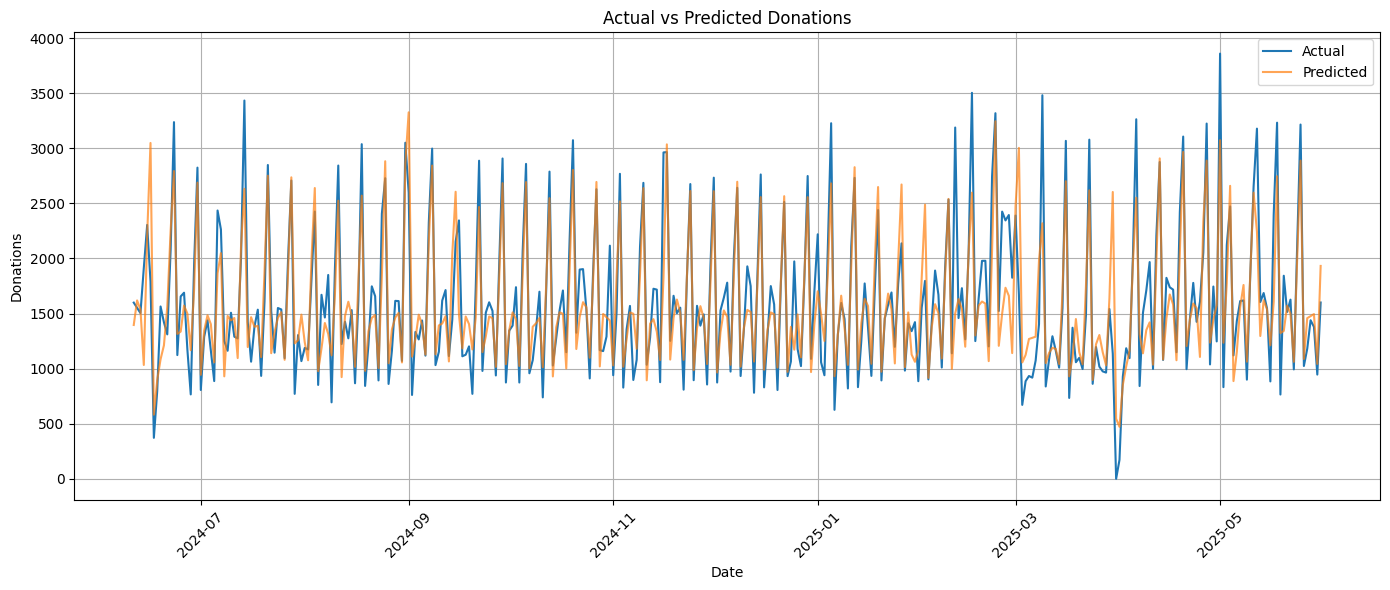

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
3188.0,1501.0,1687.0,2025-02-11,1687.0
1136.0,2603.0,-1467.0,2025-03-30,1467.0
1674.0,3003.0,-1329.0,2025-03-02,1329.0
1789.0,3048.0,-1259.0,2024-06-16,1259.0
3481.0,2319.0,1162.0,2025-03-09,1162.0
…,…,…,…,…
2535.0,2540.0,-5.0,2025-02-09,5.0
1079.0,1083.0,-4.0,2025-04-14,4.0
1449.0,1446.0,3.0,2025-04-22,3.0


In [20]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted", alpha=0.7)
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pred_df.sort(by='abs_diff', descending=True)

In [16]:
pred_df['y_true'].mean()

1611.2845070422536

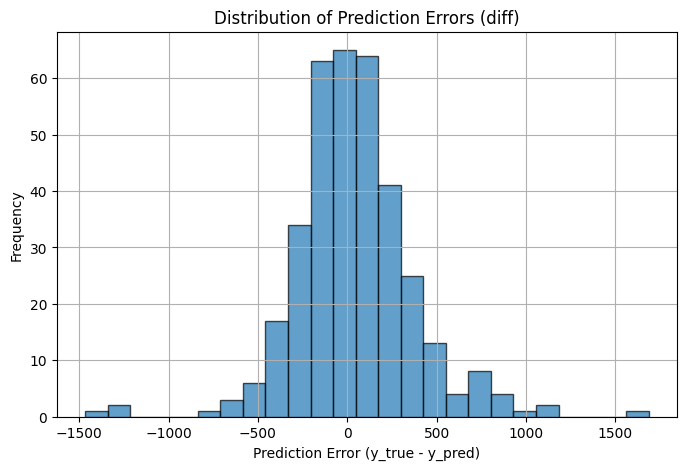

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(pred_df["diff"], bins=25, edgecolor='k', alpha=0.7)
plt.title("Distribution of Prediction Errors (diff)")
plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()